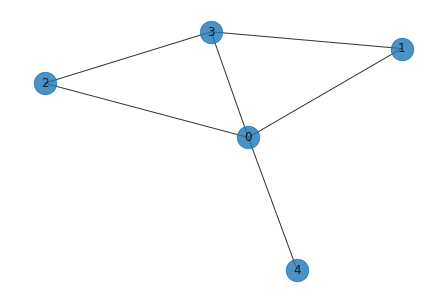

In [37]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1), (0, 2), (0, 3), (0, 4), (1,3), (2,3)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

In [38]:
# Circuits for Hamiltonians

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
from qiskit.circuit import Parameter
import pandas as pd
import numpy as np

V = G.number_of_nodes()
E = G.number_of_edges()

EdgeNumber = {}        
  
curNumber = 0    
for i in G.edges():
    EdgeNumber[i] = curNumber
    print('edge ' + str(i) + ' has number ' + str(curNumber))
    curNumber += 1

AdjacentEdges = {}    

A = nx.to_pandas_adjacency(G, dtype=int)

for z in G.edges():
    i = z[0]
    j = z[1]
    l = EdgeNumber[(i,j)]
    AdjacentEdges[l] = []

for z in G.edges():
    i = z[0]
    j = z[1]
    l = EdgeNumber[(i,j)]
    for k in range(0, V):
        if A[i][k] != 0 and k != j:
            if (i,k) in EdgeNumber:
                t = EdgeNumber[(i,k)]
            else:
                t = EdgeNumber[(k,i)]
            if l not in AdjacentEdges[t]:
                AdjacentEdges[l].append(t)
    for k in range(0, V):
        if A[j][k] != 0 and k != i:
            if (j,k) in EdgeNumber:
                t = EdgeNumber[(j,k)]
            else:
                t = EdgeNumber[(k,j)]
            if l not in AdjacentEdges[t]:
                AdjacentEdges[l].append(t)

for i in AdjacentEdges:
    print('edge number ' + str(i) + ' shares a vertex with edges ' + str(AdjacentEdges[i]))        
            
def QC_mix(beta):
    QC_mixBeta = QuantumCircuit(2 * E, 2 * E)
    for i in range(2 * E):
        QC_mixBeta.rx(2 * beta, i)
    return QC_mixBeta

def QC_problem(gamma):
    QC_problemGamma = QuantumCircuit(2 * E, 2 * E)
    for i in range(0, E):
        for j in AdjacentEdges[i]:
            QC_problemGamma.cx(2*i,2*i+1)
            QC_problemGamma.cx(2*i+1,2*j)
            QC_problemGamma.cx(2*j,2*j+1)
            QC_problemGamma.rz(2 * gamma, 2*j+1)
            QC_problemGamma.cx(2*j,2*j+1)
            QC_problemGamma.cx(2*i+1,2*j)
            QC_problemGamma.cx(2*i,2*i+1)
        
            QC_problemGamma.cx(2*i,2*j)
            QC_problemGamma.rz(2 * gamma, 2*j)
            QC_problemGamma.cx(2*i,2*j)
        
            QC_problemGamma.cx(2*i+1,2*j+1)
            QC_problemGamma.rz(2 * gamma, 2*j+1)
            QC_problemGamma.cx(2*i+1,2*j+1)
        
            QC_problemGamma.barrier()
            
    return QC_problemGamma

def QAOA(beta, gamma, p):
    QAOAcircuit = QuantumCircuit(2 * E, 2 * E)
    for i in range(0, 2 * E):
        QAOAcircuit.h(i)
    for i in range(p):
        QAOAcircuit = QAOAcircuit.compose(QC_problem(gamma[i])) 
        QAOAcircuit = QAOAcircuit.compose(QC_mix(beta[i])) 
    QAOAcircuit.measure(range(2*E), range(2*E))
    return QAOAcircuit
    
#%matplotlib inline
#QAOA.draw(output='mpl')




edge (0, 1) has number 0
edge (0, 2) has number 1
edge (0, 3) has number 2
edge (0, 4) has number 3
edge (1, 3) has number 4
edge (2, 3) has number 5
edge number 0 shares a vertex with edges [1, 2, 3, 4]
edge number 1 shares a vertex with edges [2, 3, 5]
edge number 2 shares a vertex with edges [3, 4, 5]
edge number 3 shares a vertex with edges []
edge number 4 shares a vertex with edges [5]
edge number 5 shares a vertex with edges []


In [39]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, BasicAer, execute
from qiskit.quantum_info.states.quantum_state import QuantumState
import qiskit.quantum_info as qi
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from numpy import pi
from scipy.optimize import minimize
from operator import itemgetter

def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items()}

def coloring_obj(x):
    val = 0
    for i in range(0, E):
        for j in AdjacentEdges[i]:
            if x[2*i] == x[2*j] and x[2*i+1] == x[2*j+1]:
                # pair of adjacent edges of coinciding color
                val += 1
    return val

def compute_coloring_energy(counts):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():
        obj_for_meas = coloring_obj(meas)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return energy / total_counts


def get_black_box_objective(p):
    backend = BasicAer.get_backend('qasm_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        beta = theta[:p]
        gamma = theta[p:]
        qc = QAOA(beta, gamma, p)
        counts = execute(qc, backend, seed_simulator=10).result().get_counts()
        # return the energy
        return compute_coloring_energy(invert_counts(counts))
    return f

p = 4
obj = get_black_box_objective(p)

init_point = np.array([1.86477138, 4.74777931, 1.79736975, 3.5114647, 1.34860739,
       0.82412463, 0.83044571, 1.48318042])
# We are going to limit the number of iterations to 2500
res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':10000, 'disp': True})

print(res_sample)

optimal_theta = res_sample['x']
qc = QAOA(optimal_theta[:p], optimal_theta[p:], p)
backend = BasicAer.get_backend('qasm_simulator')

counts = invert_counts(execute(qc, backend).result().get_counts())

counts = sorted(counts.items(), key=itemgetter(1), reverse=True)

counts


     fun: 0.9287109375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 94
  status: 1
 success: True
       x: array([3.19200043, 4.47498165, 1.4285521 , 2.97824857, 1.21867267,
       0.52838491, 0.63366963, 1.20287267])


[('001101101000', 12),
 ('111001000011', 12),
 ('010010111101', 12),
 ('111000010111', 11),
 ('111001001000', 9),
 ('100111000010', 9),
 ('001110011101', 9),
 ('100001110010', 9),
 ('100011010110', 8),
 ('011110001101', 8),
 ('101101000010', 8),
 ('110010010011', 8),
 ('000111101000', 7),
 ('100011010010', 7),
 ('001101101100', 7),
 ('001011011001', 7),
 ('101100010110', 7),
 ('110101101000', 7),
 ('000110111100', 7),
 ('110100101011', 7),
 ('011100101110', 7),
 ('110100100110', 7),
 ('101100011110', 6),
 ('000111100110', 6),
 ('011000111001', 6),
 ('100011010001', 6),
 ('010010111111', 6),
 ('001110011100', 6),
 ('010010110011', 6),
 ('011011001001', 6),
 ('010011100001', 6),
 ('101101001100', 6),
 ('100001111110', 6),
 ('011110000001', 6),
 ('001011011000', 6),
 ('011011001000', 5),
 ('110100100111', 5),
 ('011000111110', 5),
 ('100100111110', 5),
 ('011100101001', 5),
 ('110001100011', 5),
 ('011110001100', 5),
 ('110110000011', 5),
 ('001110010100', 5),
 ('011000110111', 5),
 ('100

The minimal energy is 1.5205078125, beta = 1.382300767579509, gamma = 1.7592918860102842


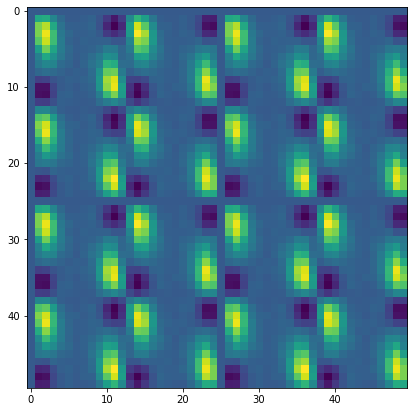

In [40]:
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

n = 50

s = (n,n)
energy = np.zeros(s)

minEnergy = 6

for i in range(n):
    for j in range(n):
        beta = 2 * i * np.pi / n
        gamma = 2 * j * np.pi / n
        circuit = QuantumCircuit(2 * E, 2 * E)
        for t in range(0, 2 * E):
            circuit.h(t)
        circuit = circuit.compose(QC_problem(gamma)) 
        circuit = circuit.compose(QC_mix(beta)) 
        circuit.measure(range(2*E), range(2*E))
        counts = execute(circuit, backend, seed_simulator=10).result().get_counts()
        energy[i][j] = compute_coloring_energy(invert_counts(counts))
        if energy[i][j] < minEnergy:
            minBeta = beta
            minGamma = gamma
            minEnergy = energy[i][j]
            #Imin = i
            #Jmin = j
        
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(energy) #, cmap = "Blues")
print('The minimal energy is ' + str(minEnergy) + ', beta = ' + str(minBeta) + ', gamma = ' + str(minGamma)) # + ', index is ' + str(i) + ',' + str(j))
#print(np.max(energy))

#for i in range(n):
 #   for j in range(n):
  #      energy[i][j] = round(energy[i][j], 2)
#print(energy)



In [74]:
def coloring_obj(x):
    val = 0
    for i in range(0, E):
        for j in AdjacentEdges[i]:
            if x[2*i] == x[2*j] and x[2*i+1] == x[2*j+1]:
                # pair of adjacent edges of coinciding color
                val += 1
    return val

t = coloring_obj('0010011110')
print(t)

0
